In [26]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import top_k_accuracy_score, accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [27]:
df = pd.read_csv('./data/HAM10000_Metadata')

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [28]:
df['age'] = df['age'].fillna(0)

In [29]:
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append(0.0)
    elif df.iloc[i]['dx'] == 'nv':
        risk.append(1.0)
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append(2.0)
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append(3.0)
        
df['risk'] = risk

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,0.0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,0.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,0.0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,0.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,0.0


In [30]:
feature_vector = []
y = []

for i in tqdm(range(0, 10015)):
    sex = [0, 0]
    if df.iloc[i]['sex'] == 'male':
        sex = [1, 0]
    elif df.iloc[i]['sex'] == 'female':
        sex = [0, 1]
    
    y.append(df.iloc[i]['risk'])
    
    age = df.iloc[i]['age']
        
    loc = df.iloc[i]['localization']
    
    sex.append(age)
    feat = np.array(sex)
    
    if loc == 'abdomen':
        feat = np.concatenate((feat, tf.one_hot(0, 14)))
    elif loc == 'scalp':
        feat = np.concatenate((feat, tf.one_hot(1, 14)))
    elif loc == 'lower extremity':
        feat = np.concatenate((feat, tf.one_hot(2, 14)))
    elif loc == 'trunk':
        feat = np.concatenate((feat, tf.one_hot(3, 14)))
    elif loc == 'upper extremity':
        feat = np.concatenate((feat, tf.one_hot(4, 14)))
    elif loc == 'back':
        feat = np.concatenate((feat,tf.one_hot(5, 14)))
    elif loc == 'neck':
        feat = np.concatenate((feat,tf.one_hot(6, 14)))
    elif loc == 'face':
        feat = np.concatenate((feat,tf.one_hot(7, 14)))
    elif loc == 'chest':
        feat = np.concatenate((feat,tf.one_hot(8, 14)))
    elif loc == 'foot':
        feat = np.concatenate((feat,tf.one_hot(9, 14)))
    elif loc == 'ear':
        feat = np.concatenate((feat,tf.one_hot(10, 14)))
    elif loc == 'unknown':
        feat = np.concatenate((feat, np.zeros(14)))
    elif loc == 'hand':
        feat = np.concatenate((feat,tf.one_hot(11, 14)))
    elif loc == 'acral':
        feat = np.concatenate((feat,tf.one_hot(12, 14)))
    elif loc == 'genital':
        feat = np.concatenate((feat,tf.one_hot(13, 14)))

    feature_vector.append(feat)

feat_X = np.array(feature_vector)
y = np.array(y)

100%|███████████████████████████████████| 10015/10015 [00:02<00:00, 4876.48it/s]


In [31]:
class_weight = {0.0: 5.75, 1.0: 1, 2.0:20, 3.0: 5}

In [32]:
clf = SVC(class_weight=class_weight, decision_function_shape='ovo', probability=True)
clf.fit(feat_X, y)

SVC(class_weight={0.0: 5.75, 1.0: 1, 2.0: 20, 3.0: 5},
    decision_function_shape='ovo', probability=True)

In [33]:
pred_y = clf.predict(feat_X)

In [34]:
accuracy_score(y, pred_y)

0.6117823265102347

In [35]:
precision_recall_fscore_support(y, pred_y)

(array([0.27876106, 0.85589976, 0.18106996, 0.30016103]),
 array([0.13938053, 0.73348248, 0.26911315, 0.57283344]),
 array([0.18584071, 0.78997671, 0.21648216, 0.39391378]),
 array([1356, 6705,  327, 1627]))

In [36]:
cm = confusion_matrix(y, pred_y)

In [37]:
new_cm = [[],[],[],[]]
new_cm[0] = cm[0] / (1.0 * cm[0].sum())
new_cm[1] = cm[1] / (1.0 * cm[1].sum())
new_cm[2] = cm[2] / (1.0 * cm[2].sum())
new_cm[3] = cm[3] / (1.0 * cm[3].sum())

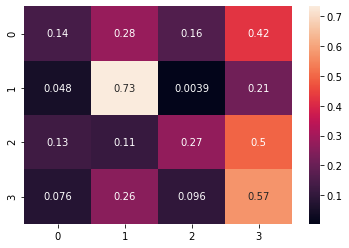

In [38]:
sns.heatmap(new_cm, annot=True);

In [39]:
clf.predict_proba(feat_X[8000].reshape(1, -1))

array([[0.17810769, 0.52624648, 0.02930408, 0.26634175]])

In [40]:
y[8000]

1.0

In [41]:
clf2 = LogisticRegression(random_state=0, class_weight='balanced', multi_class='ovr').fit(feat_X, y)

/Users/owenpi/miniforge3/envs/m1tf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/owenpi/miniforge3/envs/m1tf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

In [42]:
pred_y = clf2.predict(feat_X)

In [43]:
accuracy_score(y, pred_y)

0.6300549176235647

In [44]:
precision_recall_fscore_support(y, pred_y)

(array([0.35249042, 0.87031749, 0.13317191, 0.3372549 ]),
 array([0.20353982, 0.77270694, 0.50458716, 0.42286417]),
 array([0.25806452, 0.81861274, 0.21072797, 0.37523861]),
 array([1356, 6705,  327, 1627]))

In [45]:
cm = confusion_matrix(y, pred_y)

In [46]:
new_cm = [[],[],[],[]]
new_cm[0] = cm[0] / (1.0 * cm[0].sum())
new_cm[1] = cm[1] / (1.0 * cm[1].sum())
new_cm[2] = cm[2] / (1.0 * cm[2].sum())
new_cm[3] = cm[3] / (1.0 * cm[3].sum())

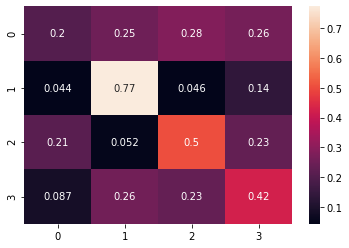

In [47]:
sns.heatmap(new_cm, annot=True);

In [48]:
clf2.predict_proba(feat_X[0].reshape(1, -1))

array([[0.32898442, 0.02392379, 0.34739504, 0.29969675]])

In [57]:
clf3 = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample').fit(feat_X, y)

In [58]:
pred_y = clf3.predict(feat_X)

In [59]:
accuracy_score(y, pred_y)

0.6332501248127809

In [60]:
precision_recall_fscore_support(y, pred_y)

(array([0.38592233, 0.88864981, 0.16655607, 0.38820059]),
 array([0.35176991, 0.73914989, 0.7675841 , 0.40442532]),
 array([0.36805556, 0.80703468, 0.27371865, 0.3961469 ]),
 array([1356, 6705,  327, 1627]))

In [61]:
cm = confusion_matrix(y, pred_y)

In [62]:
new_cm = [[],[],[],[]]
new_cm[0] = cm[0] / (1.0 * cm[0].sum())
new_cm[1] = cm[1] / (1.0 * cm[1].sum())
new_cm[2] = cm[2] / (1.0 * cm[2].sum())
new_cm[3] = cm[3] / (1.0 * cm[3].sum())

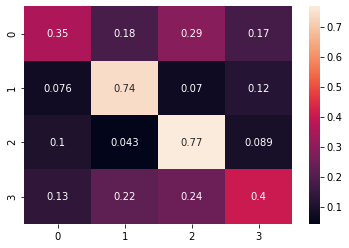

In [63]:
sns.heatmap(new_cm, annot=True);

In [64]:
clf3.predict_proba(feat_X[:1])

array([[0.25694196, 0.0117782 , 0.60280293, 0.12847692]])